# Modeling
By Joshua Mayes 08/07/2022

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import metrics


import wrangle
import my_toolkit

SEED = 8

In [2]:
pd.options.display.max_columns = None

## About this Notebook

In this notebook we will be building and evaluating the performance of machine learning models and selecting the best performer.

### Notebook plan
- Prepare data
    - Scale
    - Cluster
    - Dummy columns
- Models
    - LR on only clusters
    - LR on each cluster only
    - RFR on entire dataset

## Prepare data

### Config variables and helper functions

During exploration I was able to identify some useful clusters.  These variable will help cleanly create those clusters.

In [3]:
## Import the data
train, test, validate = wrangle.wrangle_zillow()
## Make a backup in case I mess something up later
orig_samples = {
    'train': train.copy(),
    'test': test.copy(),
    'validate': validate.copy()
}


In [ ]:
def build_kmeans_clusterer(df, cols, k, seed=SEED):
    from sklearn.cluster import KMeans
    clusterer = KMeans(n_clusters=k, random_state=seed)
    clusterer.fit(df[cols])
    return clusterer


def get_kmeans_clusters(df, cols, k, clusterer=None):
    if clusterer == None:
        from sklearn.cluster import KMeans
        clusterer = KMeans(n_clusters=k)
        clusterer.fit(df[cols])
    s = clusterer.predict(df[cols])
    return s


def make_minmax_scaler(df, cols):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(df[cols])
    return scaler


def df_scale_cols(df, cols, scaler, reverse=False):
    out = df.copy()
    if reverse:
        out[cols] = scaler.inverse_transform(out[cols])
    else:
        out[cols] = scaler.transform(out[cols])
    return out


### Scaling

In [8]:
scale_cols = [
#  'logerror',
 'bedroomcnt',
 'calc_bath',
 'structure_sqft',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lot_sqft',
 'roomcnt',
 'tax_structure',
 'tax',
 'tax_land',
 'years_tax_delinquent',
 'bathroom_sum',
 'age',
 ]

In [9]:
scaler1 = make_minmax_scaler(train, scale_cols)

train = df_scale_cols(train, scale_cols, scaler1)
test = df_scale_cols(test, scale_cols, scaler1)
validate = df_scale_cols(validate, scale_cols, scaler1)

### Clustering

In [11]:
cluster1_cols = ['age','tax']
clusterer1 = build_kmeans_clusterer(train, cluster1_cols, k=6)

cluster2_cols = ['latitude','longitude','age', 'tax']
clusterer2 = build_kmeans_clusterer(train, cluster2_cols, k=6)

cluster3_cols = ['latitude','longitude','structure_sqft','lot_sqft']
clusterer3 = build_kmeans_clusterer(train, cluster3_cols, k=5)

all_clusterers = [(clusterer1, cluster1_cols), (clusterer2, cluster2_cols), (clusterer3, cluster3_cols)]

In [12]:
def df_add_clusters(df: pd.DataFrame, clusterer_col_tuples: list):
    
    out = df.copy()
    for i, (clusterer, cols) in enumerate(clusterer_col_tuples):
        out['cluster'+str(i+1)] = clusterer.predict(out[cols])
    return out

In [13]:
train = df_add_clusters(train, all_clusterers)
test = df_add_clusters(test, all_clusterers)
validate = df_add_clusters(validate, all_clusterers)

In [14]:
ytrain = train.logerror
ytest = test.logerror
yval = validate.logerror

In [15]:
train.head().iloc[:,-3:]

,cluster1,cluster2,cluster3
10842,5,1,1
46666,4,5,2
29083,5,1,4
44486,4,5,2
49011,1,1,3


## Modeling

### Baseline Model

In [16]:
baseline_val = train.logerror.mean()
baseline_val

0.016146390665833673

In [17]:
class BaselineRegressor:
    """ A simple class meant to mimic sklearn's modeling methods so that I can standardize my workflow.
    Assumes that you are fitting a single predictor.  
    For multiple predictors you will need multiple instances of this class.
    
    TODO: Handle multi-dimensional predictors
    TODO: Handle saving feature names
    """
    def __init__(self):
        """This isn't needed, but I'm leaving this here to remind myself that it's a thing."""
        pass


    def fit(self, y):
        """Calculates the mean for the target variable and assigns it to this instance."""
        if len(y.shape) == 1:
            self.baseline = y.mean()
        else:
             raise ValueError('Expected a 1 dimensional array.')

    def predict(self, x):
        """Always predicts the mean value."""
        n_predictions = len(x)
        return np.full((n_predictions), self.baseline)

In [18]:
baseline = BaselineRegressor()
baseline.fit(train.logerror)
print(baseline.baseline)

0.016146390665833673


In [19]:
pred_baseline_train = baseline.predict(train)
pred_baseline_train.shape, pred_baseline_train

((24603,),
 array([0.01614639, 0.01614639, 0.01614639, ..., 0.01614639, 0.01614639,
        0.01614639]))

In [20]:
train['baseline'] = pred_baseline_train

In [21]:
train.head().iloc[:, -4:]

,cluster1,cluster2,cluster3,baseline
10842,5,1,1,0.016146
46666,4,5,2,0.016146
29083,5,1,4,0.016146
44486,4,5,2,0.016146
49011,1,1,3,0.016146


In [22]:
y_train = train.logerror

In [23]:
def regression_metrics(actual: pd.Series, predicted: pd.Series) -> dict:

    import math
    from sklearn import metrics
    
    y = actual
    yhat = predicted
    resid_p = y - yhat
    sum_of_squared_errors = (resid_p**2).sum()

    error_metrics = {
        'max_error': metrics.max_error(actual, predicted),
        'sum_squared_error' : sum_of_squared_errors,
        'mean_squared_error' : metrics.mean_squared_error(actual, predicted),
        'root_mean_squared_error' : metrics.mean_squared_error(actual, predicted, squared=False),
        'mean_aboslute_error' : metrics.mean_absolute_error(actual, predicted),
        'r2_score' : metrics.r2_score(actual, predicted, force_finite=False)
    }

    return error_metrics

In [24]:
regression_metrics(y_train, pred_baseline_train)

{'max_error': 4.6715667683058335,
 'sum_squared_error': 624.5884000681382,
 'mean_squared_error': 0.025386676424344112,
 'root_mean_squared_error': 0.15933196924768148,
 'mean_aboslute_error': 0.0674653209139151,
 'r2_score': 0.0}

In [25]:
model_metrics = {}
model_metrics['train_baseline'] = regression_metrics(ytrain, baseline.predict(ytrain))
model_metrics['test_baseline'] = regression_metrics(ytest, baseline.predict(ytest))
model_metrics['validate_baseline'] = regression_metrics(yval, baseline.predict(yval))
pd.DataFrame.from_dict(model_metrics, orient='index')

,max_error,sum_squared_error,mean_squared_error,root_mean_squared_error,mean_aboslute_error,r2_score
train_baseline,4.671567,624.588400,0.025387,0.159332,0.067465,0.000000
test_baseline,3.159542,305.544762,0.029876,0.172848,0.070545,-0.000251
validate_baseline,3.378398,295.619116,0.028906,0.170017,0.071659,-0.000021


In [26]:
def display_metrics(metrics=model_metrics):
    return pd.DataFrame.from_dict(metrics, orient='index')

### Model 1 - Clusters only (all clusters)

In [27]:
def plot_residuals(actual, predicted):
    yhat = predicted
    resid_p = actual - yhat

    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, sharey=True, figsize=(7,4))
    ax1.set_title('Predicted Residuals')
    ax1.set_ylabel('Error')
    ax1.set_xlabel('Predicted Value')
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.scatter(x=yhat, y=resid_p)
    plt.show()

In [28]:
train_c1_dummies = pd.get_dummies(train.cluster1, prefix='cluster1')
train_c2_dummies = pd.get_dummies(train.cluster2, prefix='cluster2')
train_c3_dummies = pd.get_dummies(train.cluster3, prefix='cluster3')
x1 = pd.concat([train_c1_dummies, train_c2_dummies, train_c3_dummies], axis=1)
x1.head()

,cluster1_0,cluster1_1,cluster1_2,cluster1_3,cluster1_4,cluster1_5,cluster2_0,cluster2_1,cluster2_2,cluster2_3,cluster2_4,cluster2_5,cluster3_0,cluster3_1,cluster3_2,cluster3_3,cluster3_4
10842,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
46666,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
29083,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
44486,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
49011,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [29]:
test_c1_dummies = pd.get_dummies(test.cluster1, prefix='cluster1')
test_c2_dummies = pd.get_dummies(test.cluster2, prefix='cluster2')
test_c3_dummies = pd.get_dummies(test.cluster3, prefix='cluster3')
t1 = pd.concat([test_c1_dummies, test_c2_dummies, test_c3_dummies], axis=1)

validate_c1_dummies = pd.get_dummies(validate.cluster1, prefix='cluster1')
validate_c2_dummies = pd.get_dummies(validate.cluster2, prefix='cluster2')
validate_c3_dummies = pd.get_dummies(validate.cluster3, prefix='cluster3')
v1 = pd.concat([validate_c1_dummies, validate_c2_dummies, validate_c3_dummies], axis=1)

In [30]:
y = train.logerror

In [31]:
from sklearn import linear_model
m1 = linear_model.LinearRegression()
m1.fit(x1, y)
p1 = m1.predict(x1)


In [32]:

model_metrics['train_linear_all_clusters'] = regression_metrics(p1, y)
display_metrics()

,max_error,sum_squared_error,mean_squared_error,root_mean_squared_error,mean_aboslute_error,r2_score
train_baseline,4.671567,624.588400,0.025387,0.159332,0.067465,0.000000
test_baseline,3.159542,305.544762,0.029876,0.172848,0.070545,-0.000251
validate_baseline,3.378398,295.619116,0.028906,0.170017,0.071659,-0.000021
train_linear_all_clusters,4.665447,622.056489,0.025284,0.159009,0.067918,-234.266145


Unsurprisingly.  This model doesn't work well.  Though I am curious if other algorithms can perform any better.

In [33]:
m1_a = linear_model.LassoLars(alpha=0.1, normalize=False)
m1_a.fit(x1, ytrain)
p1_a = m1_a.predict(x1)
model_metrics['train_lassolars_all_clusters'] = regression_metrics(p1_a, ytrain)
display_metrics()

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:624: RuntimeWarning: divide by zero encountered in true_divide
  output_scores = 1 - (numerator / denominator)


,max_error,sum_squared_error,mean_squared_error,root_mean_squared_error,mean_aboslute_error,r2_score
train_baseline,4.671567,624.588400,0.025387,0.159332,0.067465,0.000000
test_baseline,3.159542,305.544762,0.029876,0.172848,0.070545,-0.000251
validate_baseline,3.378398,295.619116,0.028906,0.170017,0.071659,-0.000021
train_linear_all_clusters,4.665447,622.056489,0.025284,0.159009,0.067918,-234.266145
train_lassolars_all_clusters,4.671567,624.588400,0.025387,0.159332,0.067465,-inf


It looks like I don't understand LassoLARS very well and fed it an impossible task, causing it to revert to always guess the mean.   


In [34]:
from sklearn.ensemble import RandomForestRegressor

depth_range = range(1,15)
for i in depth_range:
    m1_b = RandomForestRegressor(max_depth=i)
    m1_b.fit(x1, ytrain)
    p1_b = m1_b.predict(x1)
    model_name = 'train_RFR_depth_'+str(i)
    model_metrics[model_name] = regression_metrics(p1_b, ytrain)

display_metrics()

,max_error,sum_squared_error,mean_squared_error,root_mean_squared_error,mean_aboslute_error,r2_score
train_baseline,4.671567,624.588400,0.025387,0.159332,0.067465,0.000000
test_baseline,3.159542,305.544762,0.029876,0.172848,0.070545,-0.000251
validate_baseline,3.378398,295.619116,0.028906,0.170017,0.071659,-0.000021
train_linear_all_clusters,4.665447,622.056489,0.025284,0.159009,0.067918,-234.266145
train_lassolars_all_clusters,4.671567,624.588400,0.025387,0.159332,0.067465,-inf
train_RFR_depth_2,4.664445,622.325372,0.025295,0.159043,0.067665,-438.739929
train_RFR_depth_3,4.663796,621.855536,0.025276,0.158983,0.067772,-299.232816
train_RFR_depth_4,4.657650,621.563519,0.025264,0.158946,0.067825,-246.946578
train_RFR_depth_5,4.661924,621.312192,0.025254,0.158914,0.067892,-227.093401
train_RFR_depth_6,4.662443,621.118033,0.025246,0.158889,0.067939,-206.686403



I don't think I'll get much more out of trying to model on clusters alone.  

Moving on.

### Model group 2:
structure and lot size + location/age/tax clusters (cluster2)

#### Random Forest Regression
Since I was unable to see any linear or polynomial relationships between logerror and any other feature, random forest regression seems to be the most promising.  I'll be sticking with that from now on.

In [35]:
x2 = train[['structure_sqft','lot_sqft']]
x2 = pd.concat((x2, train_c2_dummies), axis=1)
x2.head()

,structure_sqft,lot_sqft,cluster2_0,cluster2_1,cluster2_2,cluster2_3,cluster2_4,cluster2_5
10842,0.166350,0.400547,0,1,0,0,0,0
46666,0.204610,0.490782,0,0,0,0,0,1
29083,0.221483,0.635883,0,1,0,0,0,0
44486,0.398051,0.643645,0,0,0,0,0,1
49011,0.044202,0.198289,0,1,0,0,0,0


In [36]:
cluster2_cols

['latitude', 'longitude', 'age', 'tax']

In [37]:
from sklearn.ensemble import RandomForestRegressor

depth_range = range(1,15)
for i in depth_range:
    m2_a = RandomForestRegressor(max_depth=i)
    m2_a.fit(x2, ytrain)
    p1_b = m2_a.predict(x2)
    model_name = 'train_RFR_2a_depth_'+str(i)
    model_metrics[model_name] = regression_metrics(p1_b, ytrain)


In [38]:
m2a_train_metrics = display_metrics()[display_metrics().index.str.contains('train_RFR_2a_depth_')]
m2a_train_metrics

,max_error,sum_squared_error,mean_squared_error,root_mean_squared_error,mean_aboslute_error,r2_score
train_RFR_2a_depth_1,4.673825,623.621483,0.025347,0.159209,0.067660,-1127.048719
train_RFR_2a_depth_2,4.672966,622.320539,0.025294,0.159042,0.067654,-716.260270
train_RFR_2a_depth_3,4.625962,617.818074,0.025111,0.158466,0.067707,-422.467369
train_RFR_2a_depth_4,4.512789,611.015925,0.024835,0.157591,0.067553,-260.352748
train_RFR_2a_depth_5,4.455200,597.252853,0.024276,0.155806,0.067357,-140.244036
train_RFR_2a_depth_6,4.399674,584.461910,0.023756,0.154129,0.067109,-87.151114
train_RFR_2a_depth_7,4.278510,569.090759,0.023131,0.152089,0.066806,-56.573240
train_RFR_2a_depth_8,3.916274,541.104714,0.021993,0.148302,0.066323,-33.396278
train_RFR_2a_depth_9,3.713954,525.425173,0.021356,0.146137,0.065715,-27.158405
train_RFR_2a_depth_10,3.512704,491.895008,0.019993,0.141398,0.064912,-16.065806


This model seems promising.. but random forest is prone to overfitting.  Let's compare this to out of sample data.

In [39]:
x2test = test[['structure_sqft','lot_sqft']]
x2test = pd.concat((x2test, test_c2_dummies), axis=1)
x2test.head()

,structure_sqft,lot_sqft,cluster2_0,cluster2_1,cluster2_2,cluster2_3,cluster2_4,cluster2_5
40250,0.860504,3.036606,0,0,1,0,0,0
48385,0.372624,0.981741,0,0,1,0,0,0
41410,0.099810,0.326189,0,1,0,0,0,0
29500,0.281606,0.501544,1,0,0,0,0,0
45876,0.286597,0.555879,0,0,0,0,0,1


In [40]:
x2test.shape, ytest.shape

((10227, 8), (10227,))

In [41]:
depth_range = range(1,15)
for i in depth_range:
    m2_a = RandomForestRegressor(max_depth=i)
    m2_a.fit(x2, ytrain)
    p1_b = m2_a.predict(x2test)
    model_name = 'test_RFR_2a_depth_'+str(i)
    model_metrics[model_name] = regression_metrics(p1_b, ytest)

In [42]:
m2a_test_metrics = display_metrics()[display_metrics().index.str.contains('test_RFR_2a_depth_')]
m2a_test_metrics

,max_error,sum_squared_error,mean_squared_error,root_mean_squared_error,mean_aboslute_error,r2_score
test_RFR_2a_depth_1,3.172995,305.184126,0.029841,0.172746,0.070818,-962.382972
test_RFR_2a_depth_2,3.171310,305.815248,0.029903,0.172924,0.071474,-136.227343
test_RFR_2a_depth_3,3.169124,305.665567,0.029888,0.172882,0.071516,-144.396692
test_RFR_2a_depth_4,3.168311,306.592695,0.029979,0.173144,0.072042,-95.346577
test_RFR_2a_depth_5,3.172360,306.529126,0.029973,0.173126,0.072100,-94.073310
test_RFR_2a_depth_6,3.171042,307.379317,0.030056,0.173366,0.072554,-68.283350
test_RFR_2a_depth_7,3.185620,308.326452,0.030148,0.173633,0.072971,-54.301895
test_RFR_2a_depth_8,3.175206,309.531778,0.030266,0.173972,0.073435,-42.949238
test_RFR_2a_depth_9,3.179201,310.528927,0.030364,0.174252,0.073829,-39.971051
test_RFR_2a_depth_10,3.179378,312.725024,0.030578,0.174867,0.074565,-29.130120


<AxesSubplot:>

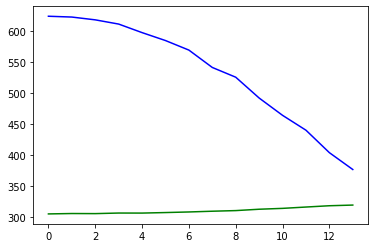

In [43]:
m2a_test_metrics.reset_index().sum_squared_error.plot.line(color='green')
m2a_train_metrics.reset_index().sum_squared_error.plot.line(color='blue')

In [44]:
display_metrics()[display_metrics().index.str.contains('RFR_2a_depth_')]

,max_error,sum_squared_error,mean_squared_error,root_mean_squared_error,mean_aboslute_error,r2_score
train_RFR_2a_depth_1,4.673825,623.621483,0.025347,0.159209,0.067660,-1127.048719
train_RFR_2a_depth_2,4.672966,622.320539,0.025294,0.159042,0.067654,-716.260270
train_RFR_2a_depth_3,4.625962,617.818074,0.025111,0.158466,0.067707,-422.467369
train_RFR_2a_depth_4,4.512789,611.015925,0.024835,0.157591,0.067553,-260.352748
train_RFR_2a_depth_5,4.455200,597.252853,0.024276,0.155806,0.067357,-140.244036
train_RFR_2a_depth_6,4.399674,584.461910,0.023756,0.154129,0.067109,-87.151114
train_RFR_2a_depth_7,4.278510,569.090759,0.023131,0.152089,0.066806,-56.573240
train_RFR_2a_depth_8,3.916274,541.104714,0.021993,0.148302,0.066323,-33.396278
train_RFR_2a_depth_9,3.713954,525.425173,0.021356,0.146137,0.065715,-27.158405
train_RFR_2a_depth_10,3.512704,491.895008,0.019993,0.141398,0.064912,-16.065806


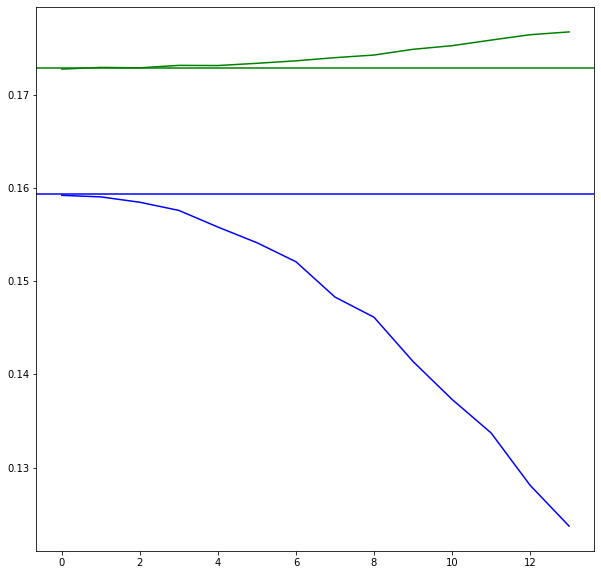

In [45]:
plt.figure(figsize=(10,10))
m2a_train_metrics.reset_index().root_mean_squared_error.plot.line(color='blue')
m2a_test_metrics.reset_index().root_mean_squared_error.plot.line(color='green')
plt.axhline(display_metrics().loc['train_baseline', 'root_mean_squared_error'], color='blue')
plt.axhline(display_metrics().loc['test_baseline', 'root_mean_squared_error'], color='green')

In [46]:
display_metrics().loc['train_baseline', 'sum_squared_error']

624.5884000681382

In [47]:
base = display_metrics()[display_metrics().index.str.contains('baseline')]
base

,max_error,sum_squared_error,mean_squared_error,root_mean_squared_error,mean_aboslute_error,r2_score
train_baseline,4.671567,624.588400,0.025387,0.159332,0.067465,0.000000
test_baseline,3.159542,305.544762,0.029876,0.172848,0.070545,-0.000251
validate_baseline,3.378398,295.619116,0.028906,0.170017,0.071659,-0.000021


### Model 3.  RFR on all clusters

In [48]:
# Get features from earlier
x3 = x1
t3 = t1
v3 = v1

In [49]:
depth_range = range(1,15)
for i in depth_range:
    m3 = RandomForestRegressor(max_depth=i)
    m3.fit(x3, ytrain)
    
    pred = m3.predict(x3)
    model_name = 'train_RFR_3_depth_'+str(i)
    model_metrics[model_name] = regression_metrics(pred, ytrain)
    
    pred = m3.predict(t3)
    model_name = 'test_RFR_3_depth_'+str(i)
    model_metrics[model_name] = regression_metrics(pred, ytest)
    


In [50]:
m3 = display_metrics()[display_metrics().index.str.contains('RFR_3_')]

In [51]:
m3 = pd.concat((m3, base))

In [52]:
m3

,max_error,sum_squared_error,mean_squared_error,root_mean_squared_error,mean_aboslute_error,r2_score
train_RFR_3_depth_1,4.668750,623.190136,0.025330,0.159154,0.067473,-873.509700
test_RFR_3_depth_1,3.167250,305.507693,0.029873,0.172837,0.070650,-1015.046633
train_RFR_3_depth_2,4.664328,622.336596,0.025295,0.159044,0.067666,-444.316237
test_RFR_3_depth_2,3.163925,305.148248,0.029838,0.172735,0.070809,-584.791421
train_RFR_3_depth_3,4.662736,621.879127,0.025277,0.158986,0.067819,-291.221295
test_RFR_3_depth_3,3.164047,304.983973,0.029821,0.172689,0.070960,-378.154718
train_RFR_3_depth_4,4.660584,621.548591,0.025263,0.158944,0.067870,-248.053872
test_RFR_3_depth_4,3.164709,304.900984,0.029813,0.172665,0.071030,-316.428043
train_RFR_3_depth_5,4.659226,621.310251,0.025253,0.158913,0.067926,-216.570379
test_RFR_3_depth_5,3.166707,304.949049,0.029818,0.172679,0.071138,-264.355839


<AxesSubplot:xlabel='root_mean_squared_error'>

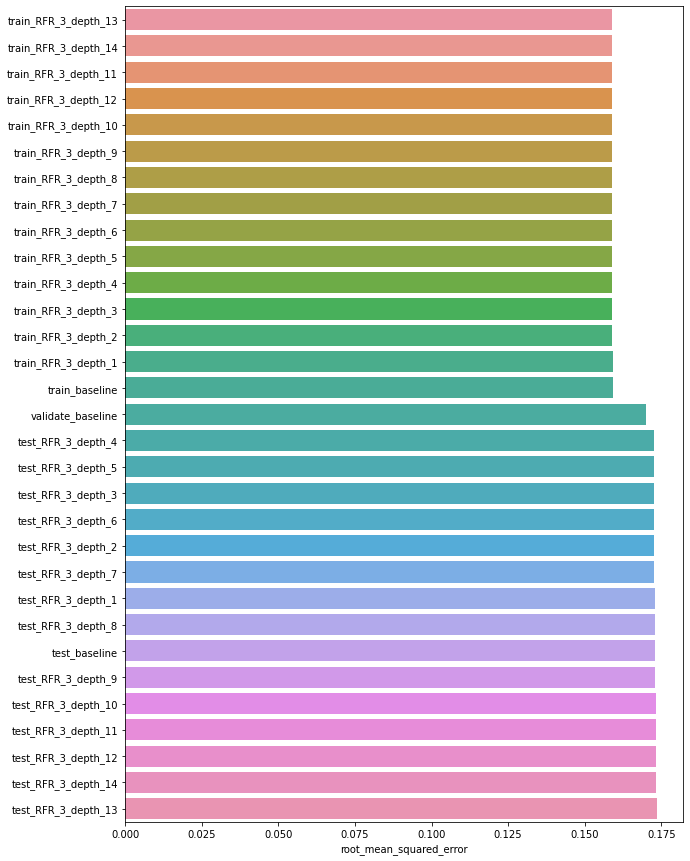

In [53]:
plt.figure(figsize=(10,15))
sns.barplot(data=m3.sort_values(by='root_mean_squared_error'), y=m3.sort_values(by='root_mean_squared_error').index, x='root_mean_squared_error')

<AxesSubplot:xlabel='root_mean_squared_error'>

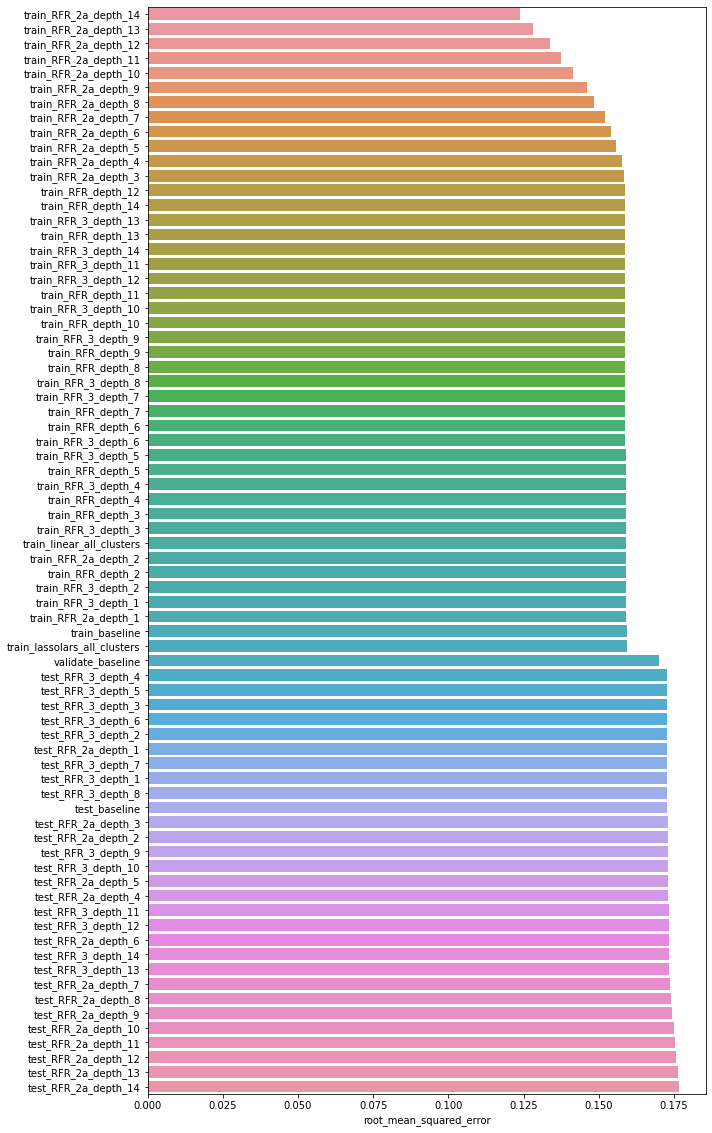

In [54]:
final_metrics = display_metrics()
plt.figure(figsize=(10,20))
sns.barplot(data=final_metrics.sort_values(by='root_mean_squared_error'), y=final_metrics.sort_values(by='root_mean_squared_error').index, x='root_mean_squared_error')

# model.py testing

In [1]:
import model

In [2]:
model.models

{'baseline': <model.BaselineRegressor at 0x152f53c29e0>,
 'linearregression_all_clusters': LinearRegression(),
 'lassolars_all_clusters': LassoLars(alpha=0.1, normalize=False),
 'randomforest_all_clusters_depth_1': RandomForestRegressor(max_depth=1),
 'randomforest_all_clusters_depth_2': RandomForestRegressor(max_depth=2),
 'randomforest_all_clusters_depth_3': RandomForestRegressor(max_depth=3),
 'randomforest_all_clusters_depth_4': RandomForestRegressor(max_depth=4),
 'randomforest_all_clusters_depth_5': RandomForestRegressor(max_depth=5),
 'randomforest_all_clusters_depth_6': RandomForestRegressor(max_depth=6),
 'randomforest_all_clusters_depth_7': RandomForestRegressor(max_depth=7),
 'randomforest_all_clusters_depth_8': RandomForestRegressor(max_depth=8),
 'randomforest_all_clusters_depth_9': RandomForestRegressor(max_depth=9),
 'randomforest_all_clusters_depth_10': RandomForestRegressor(max_depth=10),
 'randomforest_all_clusters_depth_11': RandomForestRegressor(max_depth=11),
 'ran

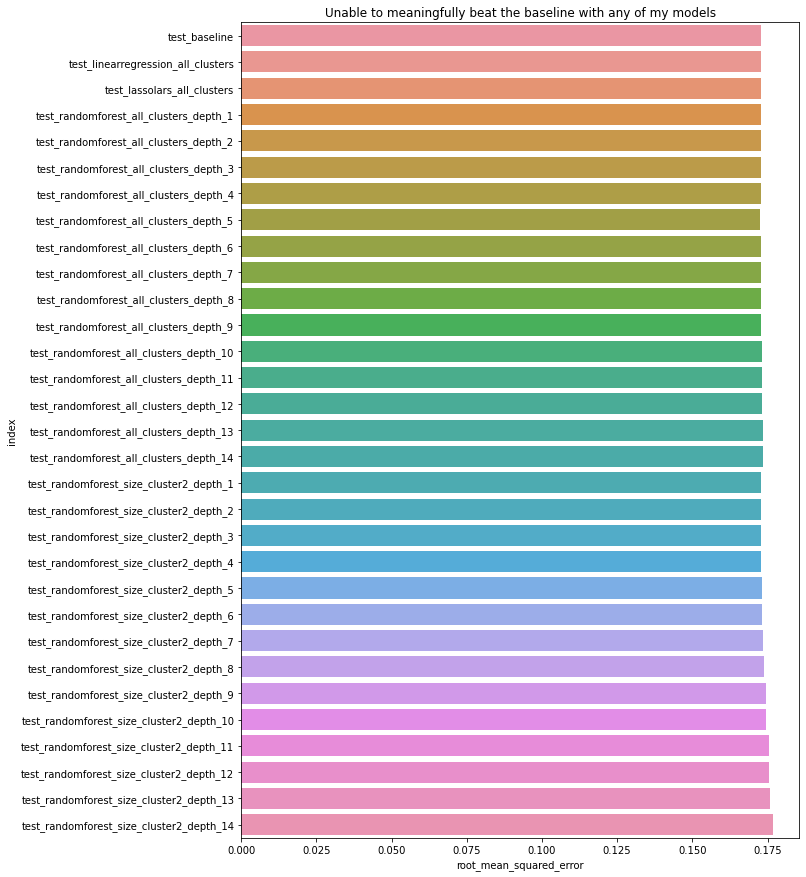

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,15))
plt.title('Unable to meaningfully beat the baseline with any of my models')
sns.barplot(data=model.df_test_metrics.reset_index(), y='index', x='root_mean_squared_error')
plt.show()